# Setup

In [1]:
%cd ..
import LLMSR
import openai
import sympy as sp
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch.nn

from kan import *
import os


/Users/kit/Documents/Phys_Working/LLM_SR/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/Users/kit/Documents/Phys_Working/LLM_SR


In [2]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("OPENROUTER_API_KEY") if os.getenv("OPENROUTER_API_KEY") else "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", 
)
LLMSR.llm.check_key_limit(client)

2025-03-11 00:44:35,576 - LLMSR.llm - INFO - API key check successful. Remaining limit: None


# First Function $e^{\sin{\pi x} + y^2}$

## Fit KAN

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.55e-03 | test_loss: 1.58e-03 | reg: 1.42e+01 | : 100%|█| 100/100 [00:25<00:00,  3.98


saving model version 0.1


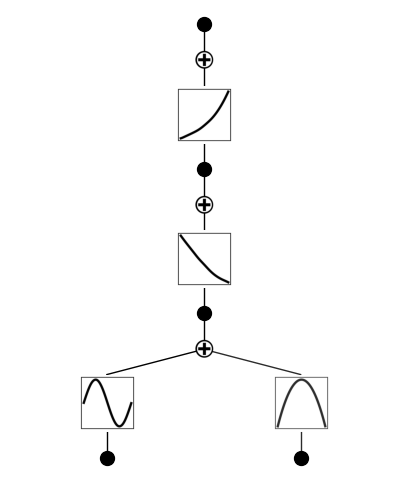

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[2,1,1,1], grid=7, k=3, seed=0, device=device, symbolic_enabled=False)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, train_num=10000, test_num=1000, device=device)
res = model.fit(dataset, opt="LBFGS", steps=100);
model.plot()

## Fit Splines

In [4]:
import importlib
import LLMSR
importlib.reload(LLMSR.response)
importlib.reload(LLMSR.images)
importlib.reload(LLMSR.llmSR)
import pickle



2025-03-11 00:45:01,150 - LLMSR.llmSR - INFO - Processing KAN model connections
2025-03-11 00:45:01,151 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,0)


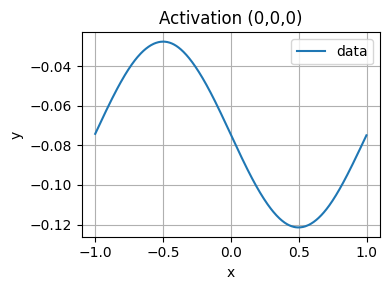

2025-03-11 00:45:01,226 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,0)
2025-03-11 00:45:01,227 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 0.1991643867800007, for constant: [-0.07408782]
2025-03-11 00:45:01,227 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 00:45:04,220 - LLMSR.llmSR - WARNING - Function conversion failed: invalid syntax (<string>, line 1)
2025-03-11 00:45:04,368 - LLMSR.llmSR - WARNING - Function conversion failed: invalid syntax (<string>, line 1)
2025-03-11 00:45:06,117 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 00:45:06,118 - LLMSR.llmSR - INFO - Initial population best: score=-0.14065519025508733, params=[-0.07480579 -0.0444165 ], ansatz: params[0] + params[1] * x...
2025-03-11 00:45:06,119 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-11 00:45:10,690 - LLMSR.llmSR - INFO - Generation 1 best: sco


API Call Statistics:
  Successful calls (end-to-end): 20
  Failed calls: 2
  Success rate: 90.91%

Breakdown by processing stage:
  Api Call: 22 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 22 succeeded, 0 failed (100.00% success)
  Function Conversion: 20 succeeded, 2 failed (90.91% success)
  Curve Fitting: 20 succeeded, 0 failed (100.00% success)

Error types:
  Function Errors:
    - syntax error: 2
Approximation for (0,0,0): params[0] + params[1] * np.sin(params[2] * x), with parameters [-0.075  0.047 -3.142]


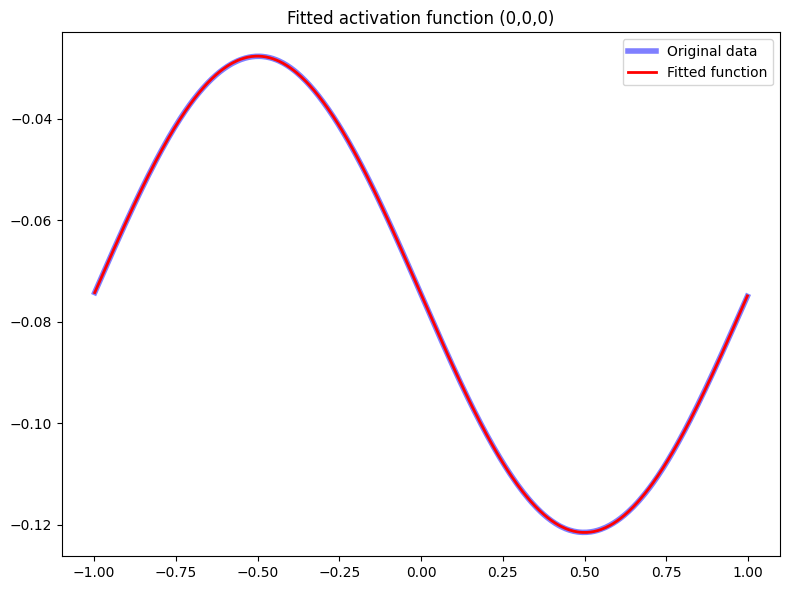

2025-03-11 00:45:10,764 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,1,0)


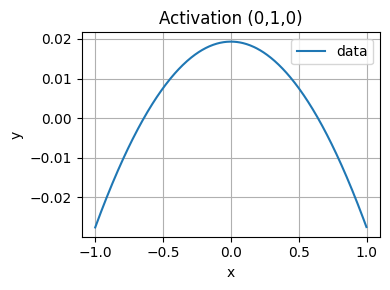

2025-03-11 00:45:10,920 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,1,0)
2025-03-11 00:45:10,921 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 17.051461557053848, for constant: [0.00328124]
2025-03-11 00:45:10,921 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 00:45:14,630 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 00:45:14,632 - LLMSR.llmSR - INFO - Initial population best: score=-1.8728077072581423e-07, params=[-0.04692208  0.01932464], ansatz: params[0] * x**2 + params[1]...
2025-03-11 00:45:14,632 - LLMSR.llmSR - INFO - Exit condition met after initial population
2025-03-11 00:45:14,632 - LLMSR.llmSR - INFO - Successfully found expression for connection (0,1,0)


Approximation for (0,1,0): params[0] * x**2 + params[1], with parameters [-0.047  0.019]


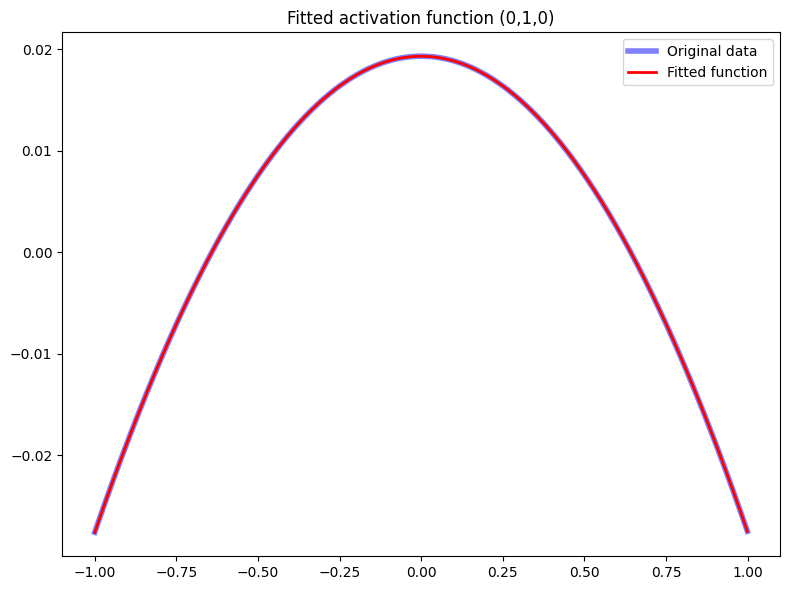

2025-03-11 00:45:14,719 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,0,0)


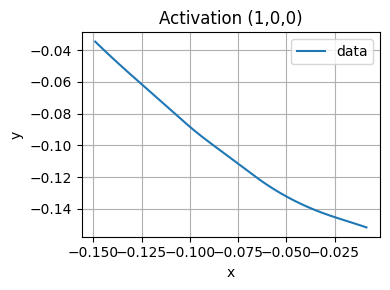

2025-03-11 00:45:14,792 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,0,0)
2025-03-11 00:45:14,792 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 0.0715603568818804, for constant: [-0.1110468]
2025-03-11 00:45:14,793 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 00:45:17,367 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 00:45:17,368 - LLMSR.llmSR - INFO - Initial population best: score=-0.0022652464147625826, params=[-0.16899723 -0.81843279], ansatz: params[0] + params[1] * x...
2025-03-11 00:45:17,369 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-11 00:45:19,662 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.00016551339595507848, params=[-0.15576285 -0.32432888  3.45090697], ansatz: params[0] + params[1] * x + params[2] * x**2...
2025-03-11 00:45:19,663 - LLMSR.llmSR - INFO - Exit condition met after generation 1: -0.0001


API Call Statistics:
  Successful calls (end-to-end): 20
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 20 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 20 succeeded, 0 failed (100.00% success)
  Function Conversion: 20 succeeded, 0 failed (100.00% success)
  Curve Fitting: 20 succeeded, 0 failed (100.00% success)

Error types:
Approximation for (1,0,0): params[0] + params[1] * x + params[2] * x**2, with parameters [-0.156 -0.324  3.451]


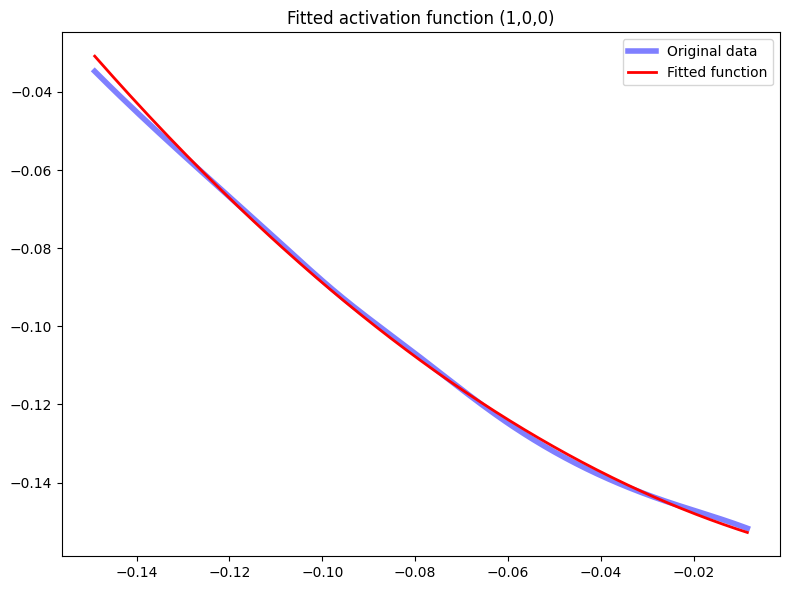

2025-03-11 00:45:19,750 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (2,0,0)


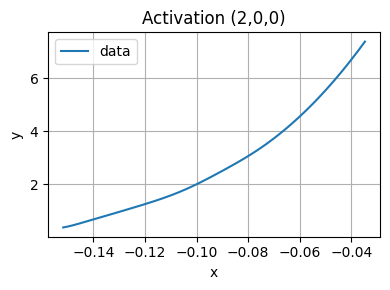

2025-03-11 00:45:19,820 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (2,0,0)
2025-03-11 00:45:19,820 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: 0.5716165298782193, for constant: [1.84716472]
2025-03-11 00:45:19,821 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-11 00:45:21,353 - LLMSR.llmSR - WARNING - Function conversion failed: invalid syntax (<string>, line 1)
2025-03-11 00:45:24,148 - LLMSR.llmSR - INFO - Generated 10 individuals asynchronously
2025-03-11 00:45:24,149 - LLMSR.llmSR - INFO - Initial population best: score=-0.005801959798783678, params=[ 10.79894681 126.69240961 387.24401604], ansatz: params[0] + params[1] * x + params[2] * x**2...
2025-03-11 00:45:24,150 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-11 00:45:25,630 - LLMSR.response - WARNING - No parameters found in initial ansatz extraction, searching full response
2025-03-11 00:45:25,


API Call Statistics:
  Successful calls (end-to-end): 20
  Failed calls: 2
  Success rate: 90.91%

Breakdown by processing stage:
  Api Call: 22 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 21 succeeded, 1 failed (95.45% success)
  Function Conversion: 20 succeeded, 1 failed (95.24% success)
  Curve Fitting: 20 succeeded, 0 failed (100.00% success)

Error types:
  Extraction Errors:
    - no parameters: 1
  Function Errors:
    - syntax error: 1
Approximation for (2,0,0): params[0] + params[1] * x + params[2] * x**2 + params[3] * np.exp(x), with parameters [-19779.845 -19579.674  -8570.101  19793.147]


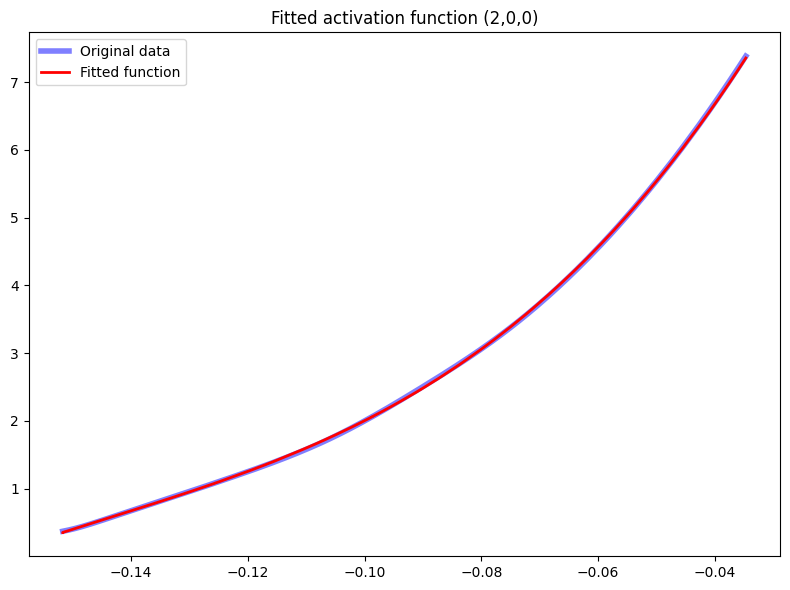

2025-03-11 00:45:33,389 - LLMSR.llmSR - INFO - KAN conversion complete: 4 total connections
2025-03-11 00:45:33,389 - LLMSR.llmSR - INFO - Connection breakdown: 0 symbolic, 0 zero, 4 processed


In [5]:
sym_expr = LLMSR.kan_to_symbolic(model, client, gpt_model="openai/gpt-4o", exit_condition=min(res['train_loss']).item(), use_async=True, population=10, generations=3, temperature=0.1)#not 10 and 3

In [6]:
with open('./sym_expr_4o_func1.pkl', 'wb') as hnd:
    pickle.dump(sym_expr, hnd)

## Reconstructing Function

In [7]:
with open('./sym_expr_4o_func1.pkl', 'rb') as hnd:
    sym_expr = pickle.load(hnd)

In [8]:
# def learned_f_handwritten(X, *params):
#     #first layer - two nodes
#     x_0_0, x_0_1 = X
#     #first splines, i = 0, j = {0,1}
#     px_0_0_0 = params[0] + params[1]*x_0_0 + params[2]*x_0_0**2 + params[3]*x_0_0**3 + params[4]*np.sin(params[5]*x_0_0)
#     px_0_0_1 = params[6] + params[7] * x_0_1 + params[8] * x_0_1**2
#     # second layer - just one node, i =
#     x_1_0 = px_0_0_0 + px_0_0_1
#     px_1_0_0 = params[9] + params[10] * x_1_0 + params[11] * x_1_0**2
#     # third layer - one node
#     x_2_0 = px_1_0_0
#     px_2_0_0 = params[12] * np.exp(params[13] * x_2_0) + params[14]
#     # fourth layer - one node
#     x_3_0 = px_2_0_0
#     return x_3_0


In [9]:
initial_params = []
for kan_conn, sub_res in sym_expr.items():
    if sub_res is None:
        print(f"Could not fit a function for connection {kan_conn}")
        continue
    highest_score_element = max((item for sublist in sub_res for item in sublist), key=lambda item: item['score'])
    print(f"Approximation for {kan_conn}: {highest_score_element['ansatz'].strip()}")
    print(f"Parameters are {np.round(highest_score_element['params'], 3)}")
    initial_params += list(highest_score_element['params'])


from LLMSR.llmSR import generate_learned_f
learned_f_string, total_params, best_params = generate_learned_f(sym_expr)
print(total_params)
print(learned_f_string)
# Execute the generated function code to create the actual function
exec(learned_f_string)

# Test the function with some parameters
print("Testing the generated function:")
test_params = np.random.uniform(-1, 1, total_params)  # Adjust size based on actual parameter count
test_input = (dataset['test_input'][0,0].item(), dataset['test_input'][0,1].item())
try:
    test_output = learned_f(test_input, *test_params)
    print(f"Input: {test_input}, Output: {test_output}")
except Exception as e:
    print(f"Error testing function: {e}")


Approximation for (0, 0, 0): params[0] + params[1] * np.sin(params[2] * x)
Parameters are [-0.075  0.047 -3.142]
Approximation for (0, 1, 0): params[0] * x**2 + params[1]
Parameters are [-0.047  0.019]
Approximation for (1, 0, 0): params[0] + params[1] * x + params[2] * x**2
Parameters are [-0.156 -0.324  3.451]
Approximation for (2, 0, 0): params[0] + params[1] * x + params[2] * x**2 + params[3] * np.exp(x)
Parameters are [-19779.845 -19579.674  -8570.101  19793.147]
12
def learned_f(X, *params):
    # Layer 0 activations
    x_0_0, x_0_1 = X
    px_0_0_0 = params[0] + params[1] * np.sin(params[2] * x_0_0)
    px_0_1_0 = params[3] * x_0_1**2 + params[4]
    x_1_0 = px_0_0_0 + px_0_1_0
    px_1_0_0 = params[5] + params[6] * x_1_0 + params[7] * x_1_0**2
    x_2_0 = px_1_0_0
    px_2_0_0 = params[8] + params[9] * x_2_0 + params[10] * x_2_0**2 + params[11] * np.exp(x_2_0)
    x_3_0 = px_2_0_0
    return x_3_0
Testing the generated function:
Input: (0.7914708852767944, -0.7126388549804688)

Mean Squared Error with optimized parameters: 0.000001
Mean Squared Error with initial parameters: 0.003401
Improvement factor: 4475.24x


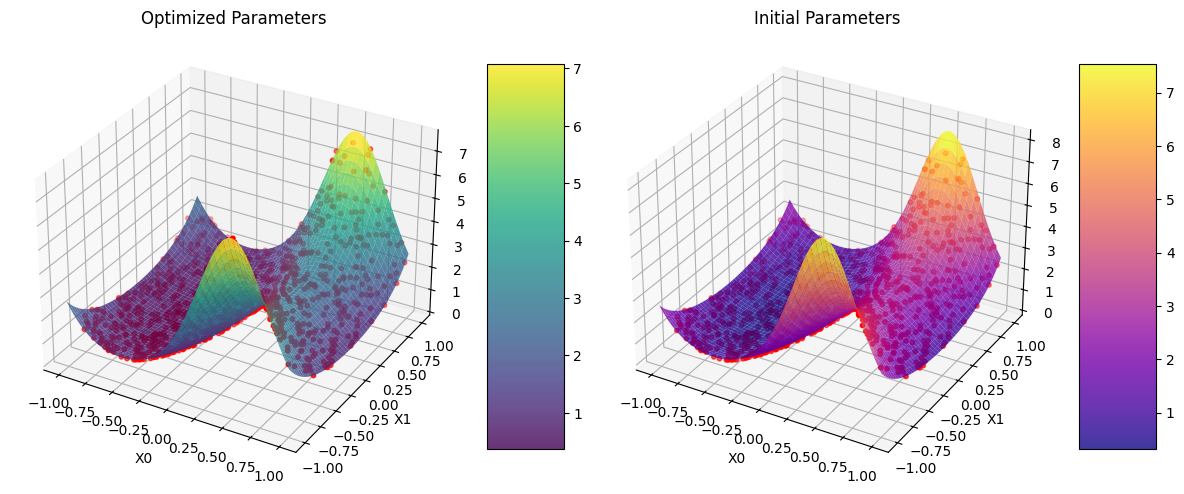

In [10]:
from scipy.optimize import curve_fit
#initial_params = np.random.uniform(-1, 1, 15)
initial_params = best_params
popt, _ = curve_fit(learned_f, (dataset['train_input'].cpu().detach().numpy()[:,0], dataset['train_input'].cpu().detach().numpy()[:,1]), dataset['train_label'].cpu().detach().numpy().flatten(), p0=initial_params, maxfev=100000)
#popt = best_params

# Plot the learned function vs the true function
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of input points
x0_range = np.linspace(min(dataset['test_input'][:,0]), max(dataset['test_input'][:,0]), 50)
x1_range = np.linspace(min(dataset['test_input'][:,1]), max(dataset['test_input'][:,1]), 50)
X0, X1 = np.meshgrid(x0_range, x1_range)

# Compute the learned function values
Z_learned = np.zeros(X0.shape)
for i in range(len(x0_range)):
    for j in range(len(x1_range)):
        Z_learned[j, i] = learned_f((X0[j, i], X1[j, i]), *popt)

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(121, projection='3d')

# Plot the learned function surface
surf = ax.plot_surface(X0, X1, Z_learned, cmap='viridis', alpha=0.8, 
                       linewidth=0, antialiased=True)

# Plot the actual test data points
test_x0 = dataset['test_input'][:,0].cpu().detach().numpy()
test_x1 = dataset['test_input'][:,1].cpu().detach().numpy()
test_y = dataset['test_label'].cpu().detach().numpy().flatten()
ax.scatter(test_x0, test_x1, test_y, c='red', marker='o', s=10, label='True data')

# Add labels and title
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('Y')
ax.set_title('Optimized Parameters')

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Calculate and print the mean squared error with optimized parameters
y_pred = np.array([learned_f((x0, x1), *popt) for x0, x1 in 
                  zip(test_x0, test_x1)])
mse_optimized = np.mean((y_pred - test_y)**2)
print(f"Mean Squared Error with optimized parameters: {mse_optimized:.6f}")

# Plot with initial parameters
ax2 = fig.add_subplot(122, projection='3d')

# Compute the function values with initial parameters
Z_initial = np.zeros(X0.shape)
for i in range(len(x0_range)):
    for j in range(len(x1_range)):
        Z_initial[j, i] = learned_f((X0[j, i], X1[j, i]), *initial_params)

# Plot the function surface with initial parameters
surf2 = ax2.plot_surface(X0, X1, Z_initial, cmap='plasma', alpha=0.8, 
                        linewidth=0, antialiased=True)

# Plot the actual test data points
ax2.scatter(test_x0, test_x1, test_y, c='red', marker='o', s=10, label='True data')

# Add labels and title
ax2.set_xlabel('X0')
ax2.set_ylabel('X1')
ax2.set_zlabel('Y')
ax2.set_title('Initial Parameters')

# Add colorbar
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

# Calculate and print the mean squared error with initial parameters
y_pred_initial = np.array([learned_f((x0, x1), *initial_params) for x0, x1 in 
                          zip(test_x0, test_x1)])
mse_initial = np.mean((y_pred_initial - test_y)**2)
print(f"Mean Squared Error with initial parameters: {mse_initial:.6f}")
print(f"Improvement factor: {mse_initial/mse_optimized:.2f}x")

plt.tight_layout()
plt.show()


# Second Function $\frac{M m}{r^2}$

# Third Function $\frac{u+v}{1+uv}$